

Sexism is a growing problem online. It can inflict harm on women who are targeted, make online spaces inaccessible and unwelcoming, and perpetuate social asymmetries and injustices. Automated tools are now widely deployed to find, and assess sexist content at scale but most only give classifications for generic, high-level categories, with no further explanation. Flagging what is sexist content and also explaining why it is sexist improves interpretability, trust and understanding of the decisions that automated tools use, empowering both users and moderators.

This project is based on SemEval 2023 - Task 10 - Explainable Detection of Online Sexism (EDOS). [Here](https://codalab.lisn.upsaclay.fr/competitions/7124#learn_the_details-overview) you can find a detailed introduction to this task.

You only need to complete **TASK A - Binary Sexism Detection: a two-class (or binary) classification where systems have to predict whether a post is sexist or not sexist**. To cut down training time, we only use a subset of the original dataset (5k out of 20k). The dataset can be found in the same folder.




In [2]:
# imports
#All finalised needed imports
import pandas as pd
import itertools
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

our_custom_stop_words = stopwords.words('english')
# removing these words from the stop words array since they are related to gender.
our_custom_stop_words.remove("he")
our_custom_stop_words.remove("him")
our_custom_stop_words.remove("himself")
our_custom_stop_words.remove("his")
our_custom_stop_words.remove("she")
our_custom_stop_words.remove("she's")
our_custom_stop_words.remove("her")
our_custom_stop_words.remove("hers")
our_custom_stop_words.remove("herself")
our_custom_stop_words.remove("they")
our_custom_stop_words.remove("them")
our_custom_stop_words.remove("their")
our_custom_stop_words.remove("theirs")
our_custom_stop_words.remove("themselves")

# Suppress warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Author: Jeziel Banos Gonzalez
# Before actual training, split data into columns and split data into X and Y train and test

All_data = pd.read_csv('edos_labelled_data.csv')

# x is the actual text, y is the sexist or not sexist label
# training data
X_train = All_data[All_data['split'] == 'train'].drop(columns=['label'])
y_train = All_data[All_data['split'] == 'train']['label']

# testing data
X_test = All_data[All_data['split'] == 'test'].drop(columns=['label'])
y_test = All_data[All_data['split'] == 'test']['label']

In [4]:
#Author: Jeziel Banos Gonzalez
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# This is the pre processing cell that actually removes and edits the text column

def remove_unwanted_text(dataframe_to_edit):
  # removes the pattern "[something here]" from the column 'text'
  # these are users, and links
  for ind in dataframe_to_edit.index:

    og_text = dataframe_to_edit['text'][ind]
    text = word_tokenize(og_text)
    cleaned_text = ""

    for word in text:

      if( not word.isnumeric() and not word.isspace()):
        if(word[0] != "[" ):
          cleaned_text +=  word+ " "
    # replace the text column with the cleaned version
    dataframe_to_edit['text'][ind] = cleaned_text.lower()



def remove_stop_words(dataframe_to_edit):
  # removes the stop words from the text column

  stop_words = set(our_custom_stop_words)
  # looping through every row
  for ind in dataframe_to_edit.index:

      og_text = dataframe_to_edit['text'][ind]
      word_tokens = word_tokenize(og_text)
      cleaned_text = ""

      for word in word_tokens:
        if not word.lower() in stop_words:
          cleaned_text += word.lower() + " "
      # replace the text column with the cleaned version
      dataframe_to_edit['text'][ind] = cleaned_text



def stem_words(dataframe_to_edit):
  # stems all the words that are left after removing stop words and unwanted patterns
  ps = PorterStemmer()
  # looping through every row
  for ind in dataframe_to_edit.index:

    og_words = dataframe_to_edit['text'][ind]
    text = word_tokenize(og_words)
    stemmed_words = ""

    for word in text:
      stemmed_words += ps.stem(word) + " "
    # replace the text column with the cleaned version
    dataframe_to_edit['text'][ind] = stemmed_words


# clean up the training data
remove_unwanted_text(X_train)
stem_words(X_train)
remove_stop_words(X_train)

# clean up the testung data
remove_unwanted_text(X_test)
stem_words(X_test)
remove_stop_words(X_test)


In [5]:
#Author: Jeziel Banos Gonzalez
#N-gram aproach (Unigrams)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# uses unigrams
vectors = CountVectorizer(min_df=1, ngram_range=(1,1)).fit(X_train['text'])
X_train_vectored = vectors.transform(X_train['text'])


# fitting the data to a logisitical regression model
LR_model = LogisticRegression()
LR_model.fit(X_train_vectored, y_train)

# predict on the testing data
test_predictions = LR_model.predict(vectors.transform(X_test['text']))
print("The accuracy of the LogisticRegression N-gram model is (test data):", accuracy_score(test_predictions, y_test))
print("\nClassification Report:\n", classification_report(y_test, test_predictions))

The accuracy of the LogisticRegression N-gram model is (test data): 0.8075506445672191

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.83      0.92      0.87       789
      sexist       0.70      0.52      0.60       297

    accuracy                           0.81      1086
   macro avg       0.77      0.72      0.73      1086
weighted avg       0.80      0.81      0.80      1086



In [6]:
coefs = np.logspace(-3, 3, 50)
max_acc = None
best_coef = None

for coef in coefs:
    svm = SVC(kernel='linear', C=coef)
    # run 2 fold cv, any higher results in large runtimes
    scores = cross_val_score(svm, X_train_vectored, y_train, cv=2)
    mean = np.mean(scores)

    # update max accuracy if new coefficient raises it
    if max_acc is None or mean > max_acc:
        max_acc = mean
        best_coef = coef

In [7]:
# Author: Jeziel Banos Gonzalez

# fitting the data to a SVC/SVM model (still using n-gram approach)
N_SVM = SVC(kernel='linear', C=best_coef)
N_SVM.fit(X_train_vectored, y_train)

# predicting with model on the testing data
X_test_transformed_N_gram_SVM = vectors.transform(X_test['text'])
predictions_N_SVM = N_SVM.predict(X_test_transformed_N_gram_SVM)

print("Accuracy of the SVC model using n-grams:", accuracy_score(y_test, predictions_N_SVM))
print("\nClassification Report:\n", classification_report(y_test, predictions_N_SVM))

Accuracy of the SVC model using n-grams: 0.8112338858195212

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.82      0.96      0.88       789
      sexist       0.79      0.42      0.55       297

    accuracy                           0.81      1086
   macro avg       0.80      0.69      0.72      1086
weighted avg       0.81      0.81      0.79      1086



In [8]:
# Author: Jeziel Banos Gonzalez

# fitting the training data to the random forest model
forest_model = RandomForestClassifier()
forest_model.fit(X_train_vectored, y_train)

# predicting with the forest model on the testing data
forest_predictions = forest_model.predict(vectors.transform(X_test['text']))
print("Accuracy of the Random Forest model using n-grams:", accuracy_score(y_test, forest_predictions))
print("\nClassification Report:\n", classification_report(y_test, forest_predictions))

Accuracy of the Random Forest model using n-grams: 0.8241252302025782

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.81      0.98      0.89       789
      sexist       0.89      0.41      0.56       297

    accuracy                           0.82      1086
   macro avg       0.85      0.69      0.72      1086
weighted avg       0.84      0.82      0.80      1086



In [9]:
#Author: Adan Baca
# encoding labels with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = X_train['text']
vectorizer = TfidfVectorizer()

#transforming and fitting the training data
vector = vectorizer.fit_transform(corpus)

#transforming the testing data
X_test_transformed = vectorizer.transform(X_test['text'])

Maximum accuracy: 0.7612698919853123
Best coefficient: 1.0


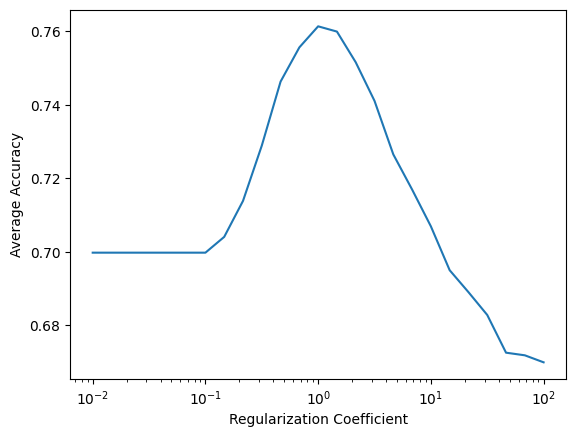

In [10]:
# Author: Adan Baca
# cross validation for optimizing regularization coefficient for SVM model

# time/performance tradeoff: shrinking this interval allowed me to run 3-fold cv
coefs = np.logspace(-2, 2, 25)

acc = [] # accuracy array to use for graphing
max_acc = None
best_coef = None

for coef in coefs:
    svm = SVC(kernel='sigmoid', C=coef)
    scores = cross_val_score(svm, vector, y_train, cv=3)
    mean = np.mean(scores)

    # update max accuracy if new coefficient raises it
    if max_acc is None or mean > max_acc:
        max_acc = mean
        best_coef = coef
    acc.append(mean)
plt.plot(coefs, acc)
plt.xscale('log')
plt.ylabel("Average Accuracy")
plt.xlabel("Regularization Coefficient")
print(f"Maximum accuracy: {max_acc}")
print(f"Best coefficient: {best_coef}")

In [11]:
# Adan Baca
# SVC using TF-IDF
SVM_og = SVC(kernel='sigmoid', C=best_coef)
SVM_og.fit(vector, y_train)
y_pred = SVM_og.predict(X_test_transformed)

print("Accuracy of SVC using TF-IDF:", accuracy_score(y_test, y_pred))
print("Classification Report of SVC using TF-IDF:\n", classification_report(y_test, y_pred))

Accuracy of SVC using TF-IDF: 0.8149171270718232
Classification Report of SVC using TF-IDF:
               precision    recall  f1-score   support

  not sexist       0.82      0.96      0.88       789
      sexist       0.79      0.44      0.57       297

    accuracy                           0.81      1086
   macro avg       0.80      0.70      0.72      1086
weighted avg       0.81      0.81      0.80      1086



In [12]:
# Author: Adan Baca
# Logistic Regression Model using TF-IDF

LR_model_TFIDF = LogisticRegression(penalty='l1', solver='liblinear')
LR_model_TFIDF.fit(vector, y_train)

test_predictions_TFIDF = LR_model_TFIDF.predict(X_test_transformed)

print("Accuracy of Logistic Regression using TF-IDF:", accuracy_score(y_test, test_predictions_TFIDF))
print("Classification Report of Logistic Regression using TF-IDF:\n", classification_report(y_test, test_predictions_TFIDF))

Accuracy of Logistic Regression using TF-IDF: 0.8149171270718232
Classification Report of Logistic Regression using TF-IDF:
               precision    recall  f1-score   support

  not sexist       0.82      0.96      0.88       789
      sexist       0.79      0.44      0.56       297

    accuracy                           0.81      1086
   macro avg       0.81      0.70      0.72      1086
weighted avg       0.81      0.81      0.80      1086



In [13]:
# Author: Adan Baca
# Random Forest Classifier using TF-IDF

rand_forest_TFIDF = RandomForestClassifier()
rand_forest_TFIDF.fit(vector, y_train)

rand_forest_TFIDF_pred = rand_forest_TFIDF.predict(X_test_transformed)

print("Accuracy of Random Forest Classifier using TF-IDF:", accuracy_score(y_test, rand_forest_TFIDF_pred))
print("\nClassification Report of Random Forest Classifier using TFIDF:\n", classification_report(y_test, rand_forest_TFIDF_pred))

Accuracy of Random Forest Classifier using TF-IDF: 0.8213627992633518

Classification Report of Random Forest Classifier using TFIDF:
               precision    recall  f1-score   support

  not sexist       0.81      0.98      0.89       789
      sexist       0.89      0.39      0.55       297

    accuracy                           0.82      1086
   macro avg       0.85      0.69      0.72      1086
weighted avg       0.83      0.82      0.80      1086



In [22]:
# When attempting to raise our F1 scores, we realized that a big issue was the
# low f1 score for sexist data. We then realized this was caused by an imbalance
# of data, with most of the data being non sexist.

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(vector, y_train)

In [23]:
# Logistic Regression using SMOTE and TF-IDF

LR_model_TFIDF_SMOTE = LogisticRegression(penalty='l1', solver='liblinear')
LR_model_TFIDF_SMOTE.fit(X_train_smote, y_train_smote)

test_predictions_TFIDF_SMOTE = LR_model_TFIDF_SMOTE.predict(X_test_transformed)

print("Accuracy of Logistic Regression using TF-IDF:", accuracy_score(y_test, test_predictions_TFIDF_SMOTE))
print("Classification Report of Logistic Regression using TF-IDF:\n", classification_report(y_test, test_predictions_TFIDF_SMOTE))

Accuracy of Logistic Regression using TF-IDF: 0.8038674033149171
Classification Report of Logistic Regression using TF-IDF:
               precision    recall  f1-score   support

  not sexist       0.88      0.85      0.86       789
      sexist       0.63      0.68      0.65       297

    accuracy                           0.80      1086
   macro avg       0.75      0.76      0.76      1086
weighted avg       0.81      0.80      0.81      1086



In [24]:
cols = [
    'Sexist Precision',
    'Sexist Recall',
    'Sexist F1',
    'Non-sexist Precision',
    'Non-sexist Recall',
    'Non-sexist F1',
    'Weighted Average Precision',
    'Weighted Average Recall',
    'Weighted Average F1'
]
models = [
    'N-grams + SVM',
    'N-grams + Logistic Regression',
    'N-grams + Random Forest',
    'TF-IDF + SVM',
    'TF-IDF + Logistic Regression',
    'TF-IDF + Random Forest',
    'TF-IDF + SMOTE + Logistic Regression'
]
results = pd.DataFrame(columns=cols, index=models)


In [25]:
results.loc['N-grams + SVM', 'Sexist Precision'] = 0.79
results.loc['N-grams + SVM', 'Sexist Recall'] = 0.42
results.loc['N-grams + SVM', 'Sexist F1'] = 0.55

results.loc['N-grams + SVM', 'Non-sexist Precision'] = 0.82
results.loc['N-grams + SVM', 'Non-sexist Recall'] = 0.96
results.loc['N-grams + SVM', 'Non-sexist F1'] = 0.88

results.loc['N-grams + SVM', 'Weighted Average Precision'] = 0.81
results.loc['N-grams + SVM', 'Weighted Average Recall'] = 0.81
results.loc['N-grams + SVM', 'Weighted Average F1'] = 0.79

results.loc['N-grams + Logistic Regression', 'Sexist Precision'] = 0.70
results.loc['N-grams + Logistic Regression', 'Sexist Recall'] = 0.52
results.loc['N-grams + Logistic Regression', 'Sexist F1'] = 0.60

results.loc['N-grams + Logistic Regression', 'Non-sexist Precision'] = 0.83
results.loc['N-grams + Logistic Regression', 'Non-sexist Recall'] = 0.92
results.loc['N-grams + Logistic Regression', 'Non-sexist F1'] = 0.87

results.loc['N-grams + Logistic Regression', 'Weighted Average Precision'] = 0.80
results.loc['N-grams + Logistic Regression', 'Weighted Average Recall'] = 0.81
results.loc['N-grams + Logistic Regression', 'Weighted Average F1'] = 0.80

results.loc['N-grams + Random Forest', 'Sexist Precision'] = 0.89
results.loc['N-grams + Random Forest', 'Sexist Recall'] = 0.39
results.loc['N-grams + Random Forest', 'Sexist F1'] = 0.54

results.loc['N-grams + Random Forest', 'Non-sexist Precision'] = 0.81
results.loc['N-grams + Random Forest', 'Non-sexist Recall'] = 0.98
results.loc['N-grams + Random Forest', 'Non-sexist F1'] = 0.89

results.loc['N-grams + Random Forest', 'Weighted Average Precision'] = 0.83
results.loc['N-grams + Random Forest', 'Weighted Average Recall'] = 0.82
results.loc['N-grams + Random Forest', 'Weighted Average F1'] = 0.79


results.loc['TF-IDF + SVM', 'Sexist Precision'] = 0.79
results.loc['TF-IDF + SVM', 'Sexist Recall'] = 0.44
results.loc['TF-IDF + SVM', 'Sexist F1'] = 0.57

results.loc['TF-IDF + SVM', 'Non-sexist Precision'] = 0.82
results.loc['TF-IDF + SVM', 'Non-sexist Recall'] = 0.96
results.loc['TF-IDF + SVM', 'Non-sexist F1'] = 0.88

results.loc['TF-IDF + SVM', 'Weighted Average Precision'] = 0.81
results.loc['TF-IDF + SVM', 'Weighted Average Recall'] = 0.81
results.loc['TF-IDF + SVM', 'Weighted Average F1'] = 0.80


results.loc['TF-IDF + Logistic Regression', 'Sexist Precision'] = 0.79
results.loc['TF-IDF + Logistic Regression', 'Sexist Recall'] = 0.44
results.loc['TF-IDF + Logistic Regression', 'Sexist F1'] = 0.56

results.loc['TF-IDF + Logistic Regression', 'Non-sexist Precision'] = 0.82
results.loc['TF-IDF + Logistic Regression', 'Non-sexist Recall'] = 0.96
results.loc['TF-IDF + Logistic Regression', 'Non-sexist F1'] = 0.88

results.loc['TF-IDF + Logistic Regression', 'Weighted Average Precision'] = 0.81
results.loc['TF-IDF + Logistic Regression', 'Weighted Average Recall'] = 0.81
results.loc['TF-IDF + Logistic Regression', 'Weighted Average F1'] = 0.80


results.loc['TF-IDF + Random Forest', 'Sexist Precision'] = 0.88
results.loc['TF-IDF + Random Forest', 'Sexist Recall'] = 0.37
results.loc['TF-IDF + Random Forest', 'Sexist F1'] = 0.52

results.loc['TF-IDF + Random Forest', 'Non-sexist Precision'] = 0.81
results.loc['TF-IDF + Random Forest', 'Non-sexist Recall'] = 0.98
results.loc['TF-IDF + Random Forest', 'Non-sexist F1'] = 0.89

results.loc['TF-IDF + Random Forest', 'Weighted Average Precision'] = 0.83
results.loc['TF-IDF + Random Forest', 'Weighted Average Recall'] = 0.81
results.loc['TF-IDF + Random Forest', 'Weighted Average F1'] = 0.79


results.loc['TF-IDF + SMOTE + Logistic Regression', 'Sexist Precision'] = 0.63
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Sexist Recall'] = 0.68
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Sexist F1'] = 0.65

results.loc['TF-IDF + SMOTE + Logistic Regression', 'Non-sexist Precision'] = 0.88
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Non-sexist Recall'] = 0.85
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Non-sexist F1'] = 0.86

results.loc['TF-IDF + SMOTE + Logistic Regression', 'Weighted Average Precision'] = 0.81
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Weighted Average Recall'] = 0.80
results.loc['TF-IDF + SMOTE + Logistic Regression', 'Weighted Average F1'] = 0.81

In [26]:
results

,Sexist Precision,Sexist Recall,Sexist F1,Non-sexist Precision,Non-sexist Recall,Non-sexist F1,Weighted Average Precision,Weighted Average Recall,Weighted Average F1
N-grams + SVM,0.79,0.42,0.55,0.82,0.96,0.88,0.81,0.81,0.79
N-grams + Logistic Regression,0.7,0.52,0.6,0.83,0.92,0.87,0.8,0.81,0.8
N-grams + Random Forest,0.89,0.39,0.54,0.81,0.98,0.89,0.83,0.82,0.79
TF-IDF + SVM,0.79,0.44,0.57,0.82,0.96,0.88,0.81,0.81,0.8
TF-IDF + Logistic Regression,0.79,0.44,0.56,0.82,0.96,0.88,0.81,0.81,0.8
TF-IDF + Random Forest,0.88,0.37,0.52,0.81,0.98,0.89,0.83,0.81,0.79
TF-IDF + SMOTE + Logistic Regression,0.63,0.68,0.65,0.88,0.85,0.86,0.81,0.8,0.81


## Summary

1. What preprocessing steps do you follow?
   
   Your answer: We removed some stop words from the text column in the given data, as well as removed [User] and [link]/[url], and other nonalphabetic data that we believe would be unnecessary for evaluating text. We also stemmed the words in the text column. One additional method we used was SMOTE, to address the issue of the data being mostly non sexist. SMOTE synthesizes new data from the preexisting data to balance out the data set.
   
   
2. How do you select the features from the inputs?
   
   Your answer: We used TF-IDF and N-grams.
   
3. Which model you use and what is the structure of your model?
   
   Your answer: We used 3 models: SVM, Logistic Regression, and Random Forest Classification. SVM works by finding the best hyperplane boundary that separates our data into classes. The closest points to the hyperplanes are called the support vectors. Logistic Regression is a model useful for binary classification, so in a case like classifying things as sexist or non-sexist, it is useful. For the SVM model we used the kernals sigmoid (TF-IDF) and linear (N-grams), which maps real numbers to a value between 0 and 1, Logistic Regression maps the probability of a data point belonging to a specific class by taking a linear combination of the data features. Random Forest Classification works by creating many decision trees, hence the name forest. The randomness comes from each tree taking a random subset of the data, and then each individual tree making a classification. The mean of the classifications is then the classification of the forest.
   
4. How do you train your model?
   
   Your answer: We train our models by preprocessing all data first. We then apply different feature engineering techniques, TF-IDF, and N-grams. TF-IDF, Term Frequency-Inverse Document Frequency, is a statistic that is the product of Term Frequency of a term, which tells how frequently a term is seen in a document, and the Inverse Document Frequency, which measures how important a term is in a document. The N-gram method collects successive words of the text and then turning them into vectors. So, a unigram only contains a single word, and a bigram contain 2. After trying with unigram, bigrams, and trigrams, unigrams preformed the best. We decided to only use unigrams for creating vectors.
   
5. What is the performance of your best model?
   
   Your answer: Our TF-IDF + SMOTE Logistic Regression had the best F1 score of 81%.
   
6. What other models or feature engineering methods would you like to implement in the future?
   
   Your answer: In the future, we would like to experiment more with Neural Networks for classifying tasks. Even though this task is a binary classification task, I assume that a neural network would increase our F1 scores a lot.
   